# TP 3 - Visión por Computadora 1


## Enunciado:

#### - Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/images a partir del template Material_TPs/template

1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos.
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del item 2
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

***

### Funciones y variables globales

In [1]:
%matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imutils


from os import listdir
from os.path import isfile, join

In [2]:
path = './images'

In [3]:
images_paths = [f'{path}/{f}' for f in listdir(path) if isfile(join(path, f))]

In [4]:
def get_image(path, color=True):
    if color:
        img = cv.imread(path, cv.IMREAD_COLOR)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        return img
    return cv.imread(path, cv.IMREAD_GRAYSCALE)

### Visualizamos las imágenes a procesar

In [5]:
images_rgb = [(get_image(path, color=True), path) for path in images_paths]

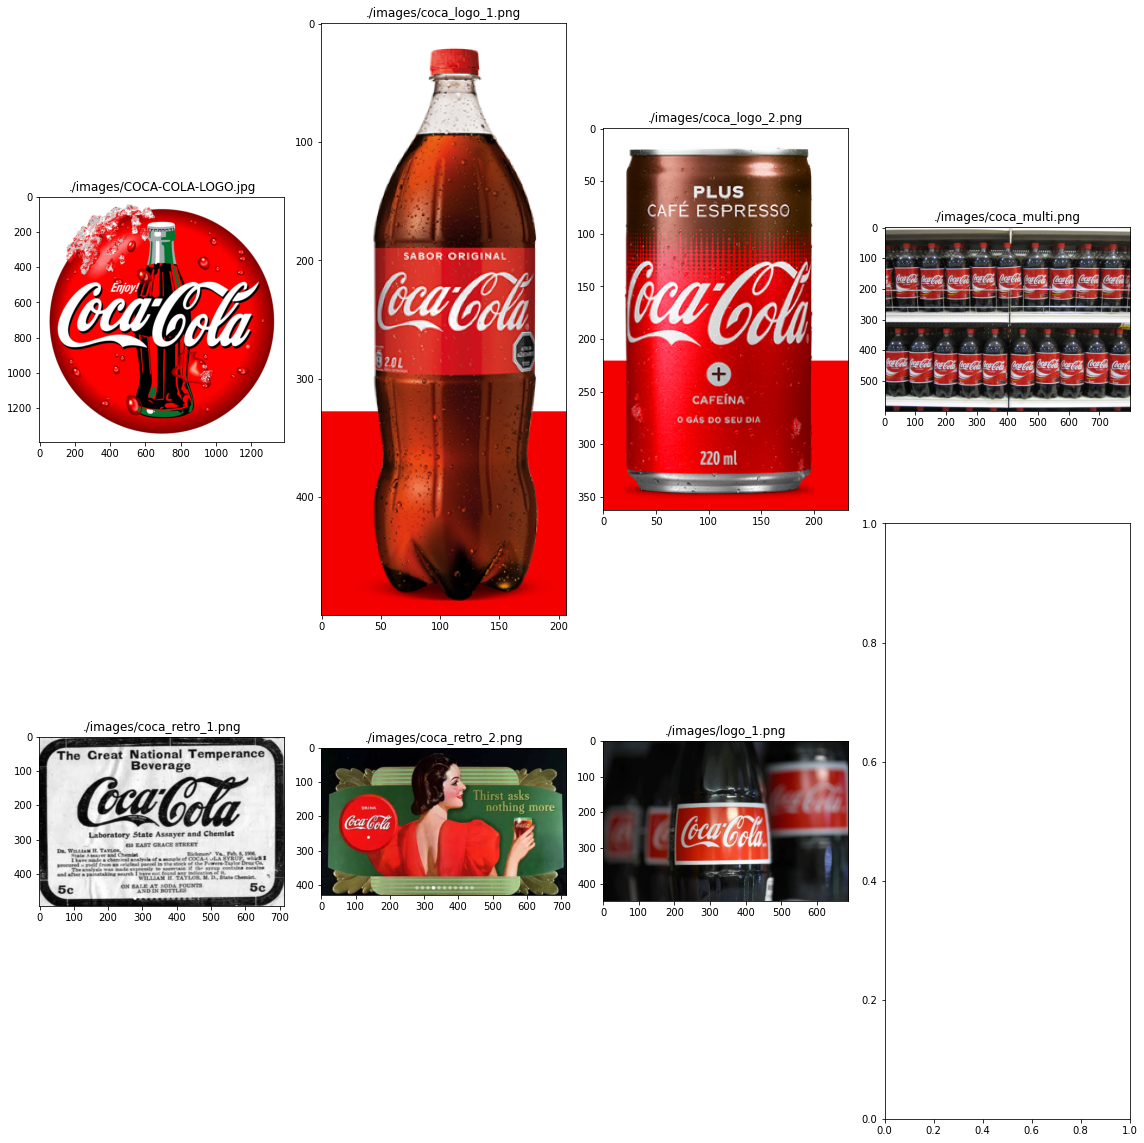

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 16))
index = 0
for row in range(2):
    for column in range(4):
        if index > 6:
            continue
        axes[row][column].imshow(images_rgb[index][0])
        axes[row][column].set_title(images_rgb[index][1])
        index += 1
fig.tight_layout()

### Visualizamos el template

In [7]:
template = get_image('./template/pattern.png')

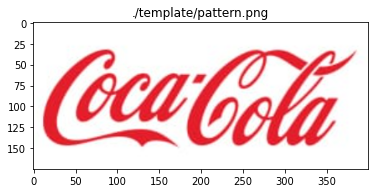

In [8]:
plt.imshow(template)
plt.title('./template/pattern.png')
plt.show()

### 1. Definimos la función general de template matching

In [9]:
images_bw = [(get_image(path, color=False), path) for path in images_paths]
template_bw = get_image('./template/pattern.png', color=False)

In [10]:
def temp_match(image, gray, template_gray, image_name, method, use_canny, force_piramyd=False,
               n_pyramids=1, multiple=False, threshold = 0.75):
    template = cv.Canny(template_gray, 50, 200)
    (tH, tW) = template.shape[:2]
    found = None
    
    if force_piramyd:
        for _ in range(n_pyramids):
            template = cv.pyrDown(template)
            (tH, tW) = template.shape[:2]
    
    while (image.shape[0] < tH or image.shape[1] < tW):
        template = cv.pyrDown(template)
        (tH, tW) = template.shape[:2]
        
    for scale in np.linspace(0.2, 1.0, 20)[::-1]:
        resized = imutils.resize(gray, width = int(gray.shape[1] * scale))
        r = gray.shape[1] / float(resized.shape[1])

        if resized.shape[0] < tH or resized.shape[1] < tW:
            break

        edged = cv.Canny(resized, 50, 200)
        img = edged if use_canny else resized
        result = cv.matchTemplate(img, template, method)
        (_, maxVal, minLoc, maxLoc) = cv.minMaxLoc(result)

        if found is None or maxVal  > found[0]:
            if multiple:
                loc = np.where( result >= threshold)
                positions = []
                for pt in zip(*loc[::-1]):
                    positions.append(pt)
                location = positions
            elif method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
                location = minLoc
            else:
                location = maxLoc     
            found = (maxVal, location, r)
    
    if multiple:
        (_, positions, r) = found
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.imshow(image)
        for position in positions:
            (startX, startY) = (int(position[0] * r), int(position[1] * r))
            (endX, endY) = (int((position[0] + tW) * r), int((position[1] + tH) * r))
            rect = patches.Rectangle((startX, startY),  int(tW * r),  int(tH * r), linewidth=3, edgecolor='g', facecolor='none')
            ax.add_patch(rect)   
        ax.set_title(image_name)
        plt.show()
    else:
        (_, maxLoc, r) = found
        (startX, startY) = (int(maxLoc[0] * r), int(maxLoc[1] * r))
        (endX, endY) = (int((maxLoc[0] + tW) * r), int((maxLoc[1] + tH) * r))

        fig, ax = plt.subplots(figsize=(16, 16))
        ax.imshow(image)
        ax.set_title(image_name)
        rect = patches.Rectangle((startX, startY),  int(tW * r),  int(tH * r), linewidth=3, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        plt.show()

### Probamos la función sobre todas las imágenes

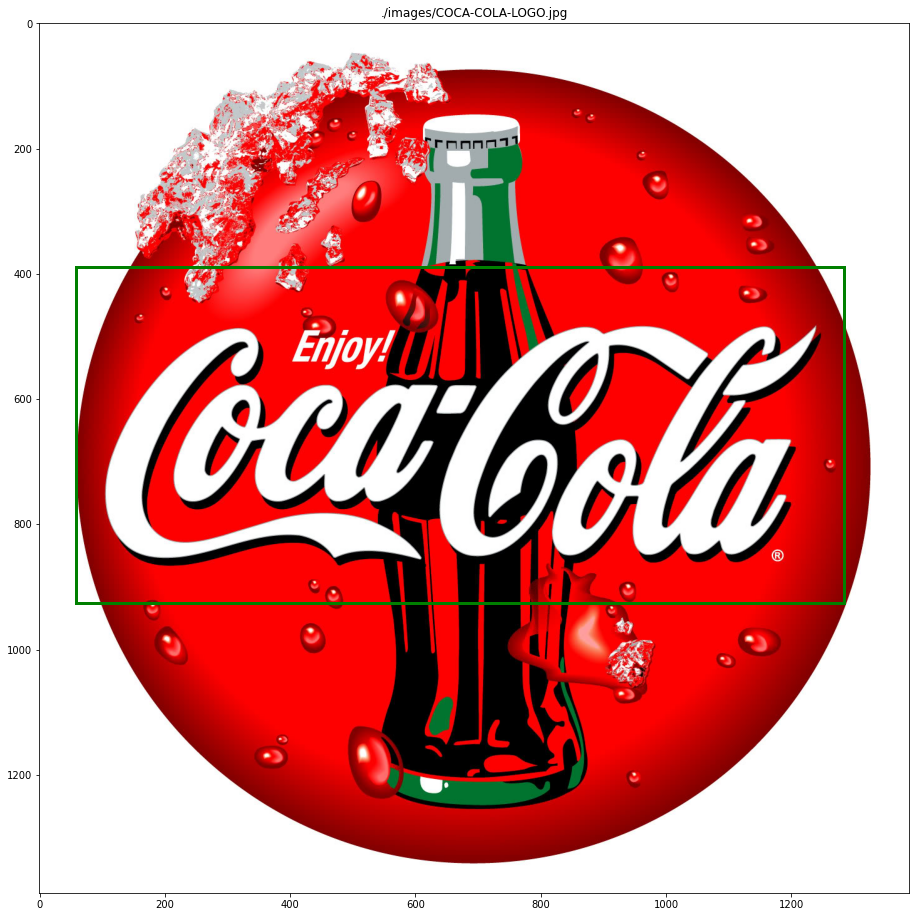

In [11]:
temp_match(image=images_rgb[0][0],
           gray=images_bw[0][0],
           template_gray=template_bw,
           image_name=images_rgb[0][1],
           method=cv.TM_CCORR_NORMED,
           use_canny=False)

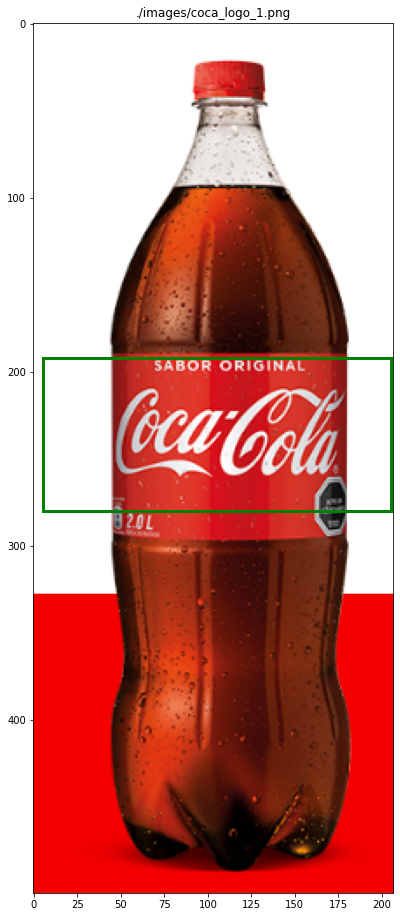

In [12]:
temp_match(image=images_rgb[1][0],
           gray=images_bw[1][0],
           template_gray=template_bw,
           image_name=images_rgb[1][1],
           method=cv.TM_CCOEFF,
           use_canny=True)

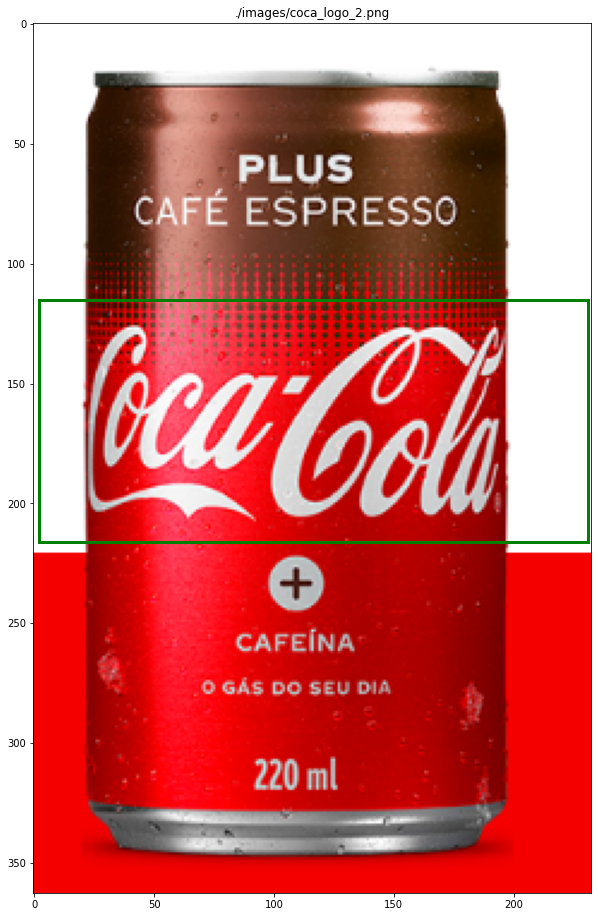

In [13]:
temp_match(image=images_rgb[2][0],
           gray=images_bw[2][0],
           template_gray=template_bw,
           image_name=images_rgb[2][1],
           method=cv.TM_CCORR,
           use_canny=False)

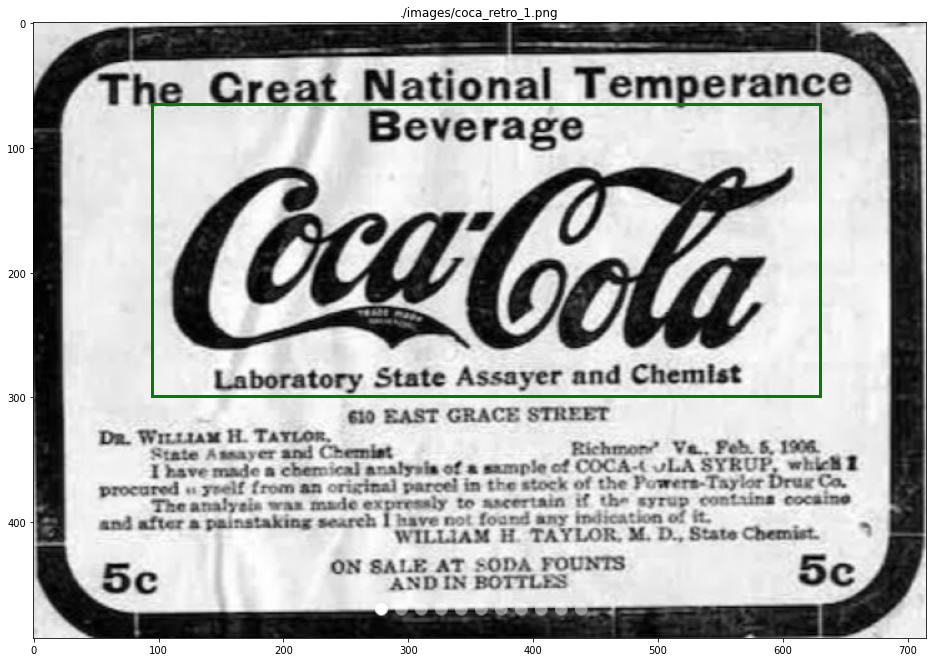

In [14]:
temp_match(image=images_rgb[4][0],
           gray=images_bw[4][0],
           template_gray=template_bw,
           image_name=images_rgb[4][1],
           method=cv.TM_CCORR_NORMED,
           use_canny=True)

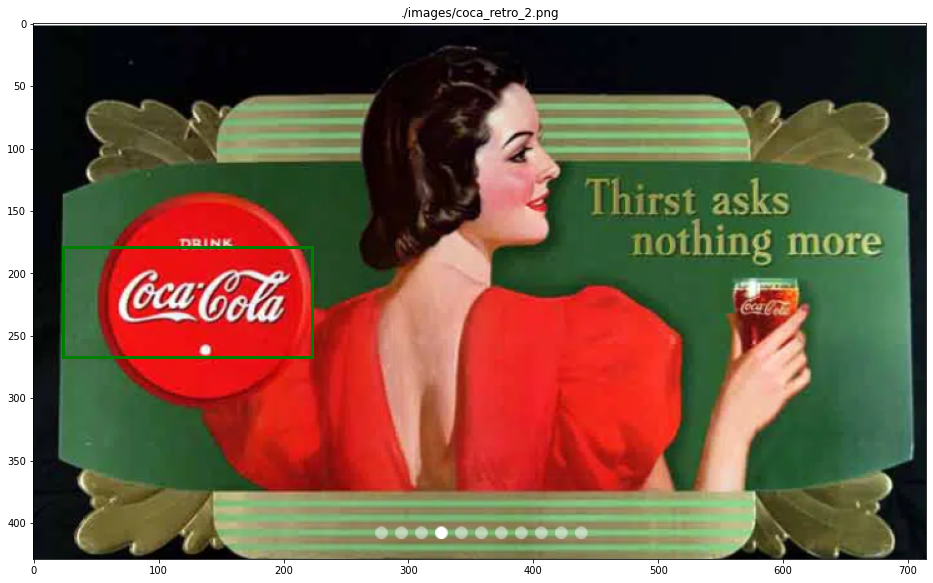

In [15]:
temp_match(image=images_rgb[5][0],
           gray=images_bw[5][0],
           template_gray=template_bw,
           image_name=images_rgb[5][1],
           method=cv.TM_CCORR_NORMED,
           use_canny=True,
           force_piramyd=True)

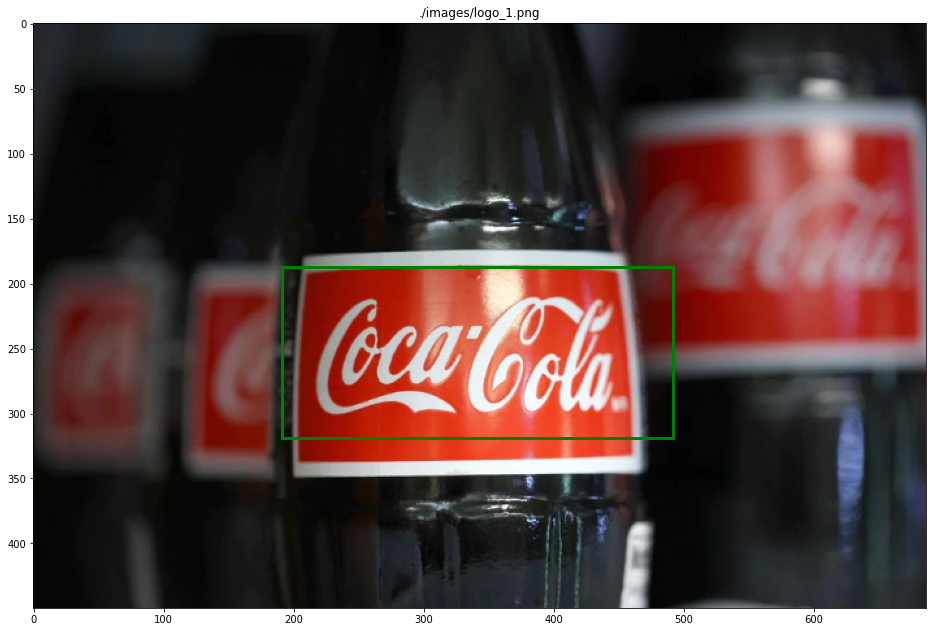

In [16]:
temp_match(image=images_rgb[6][0],
           gray=images_bw[6][0],
           template_gray=template_bw,
           image_name=images_rgb[6][1],
           method=cv.TM_CCORR_NORMED,
           use_canny=True,
           force_piramyd=True)

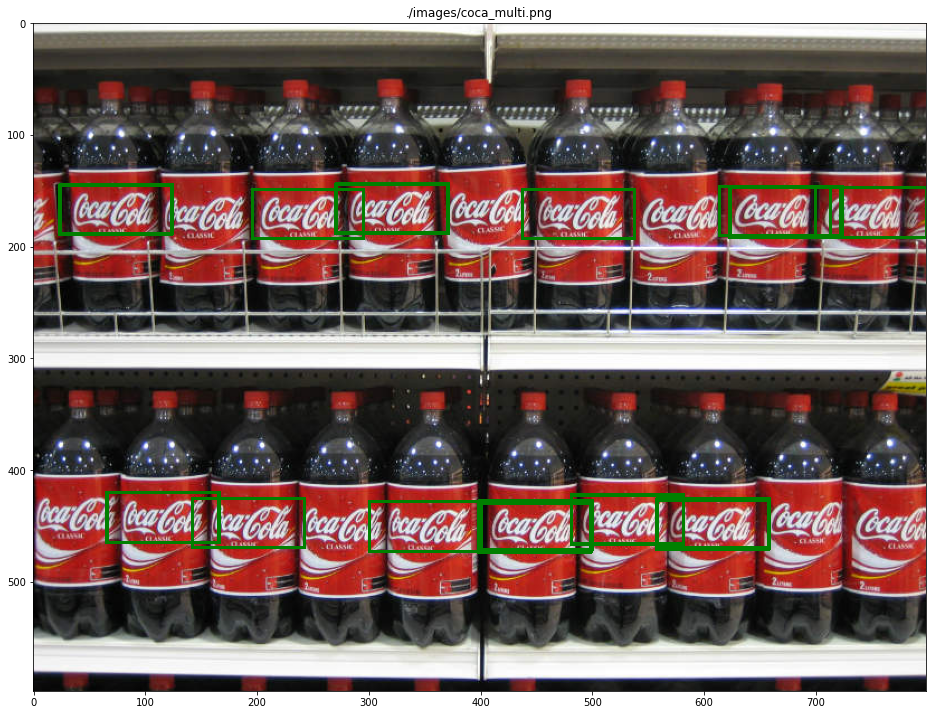

In [17]:
temp_match(image=images_rgb[3][0],
           gray=images_bw[3][0],
           template_gray=template_bw,
           image_name=images_rgb[3][1],
           method=cv.TM_CCOEFF_NORMED,
           use_canny=True,
           force_piramyd=True,
           n_pyramids=2,
           multiple=True,
           threshold=0.20)

### Conclusiones

La función desarrollada es capaz de detectar el patrón en todas las imágenes (con mayor dificultad en aquellas que presentan más de una aparición del template). No obstante, para lograr un correcto funcionamiento es necesario parametrizarla dependiendo de la imagen a procesar, es decir, para cada imagen deberemos encontrar los parámetros adecuados para poder obtener resultados satisfactorios.